# Components with hierarchy


![](https://i.imgur.com/3pczkyM.png)


You can define some components (waveguides, bends, couplers) as a stand alone components, with basic input parameters (width, length, radius ...)

Then you can re-use those components in a more complex hiearchical components.

`gdsfactory` does this by passing the higher level component with the lower level functions to build the components.

You can customize any of the functions thanks to `functools.partial`

In [1]:
import gdsfactory as gf

2022-11-07 00:08:28.355 | INFO     | gdsfactory.config:<module>:45 - Load '/home/runner/work/gdsfactory/gdsfactory/gdsfactory' 5.54.0


26.637


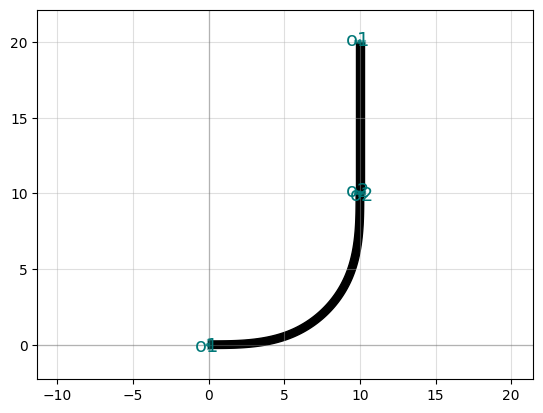

bend_with_straight: uid 87f923df, ports [], references ['bend_euler_1', 'straight_1'], 0 polygons

In [2]:
@gf.cell
def bend_with_straight(
    bend=gf.components.bend_euler,
    straight=gf.components.straight,
) -> gf.Component:
    c = gf.Component()
    b = bend()
    s = straight()

    bref = c << b
    sref = c << s

    sref.connect("o2", bref.ports["o2"])
    c.info["length"] = b.info["length"] + s.info["length"]
    return c


c = bend_with_straight()
print(c.metadata.info.length)
c

Lets **customize** the functions that we pass.
For example, we want to increase the radius of the bend from the default 10um to 20um.

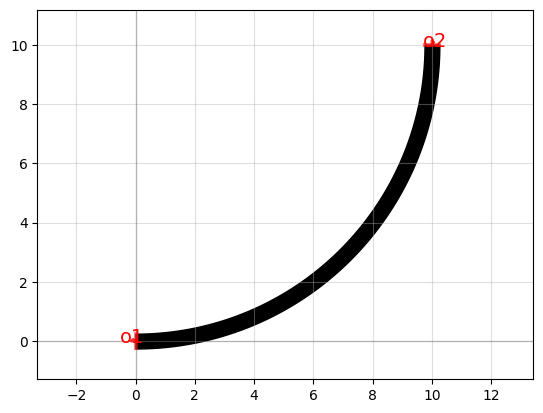

bend_circular: uid 1c69f341, ports ['o1', 'o2'], references [], 4 polygons

In [3]:
c = gf.components.bend_circular()
c

## functools.partial

Partial lets you define different default parameters for a function, so you can modify the settings for the child cells.

In [4]:
from functools import partial

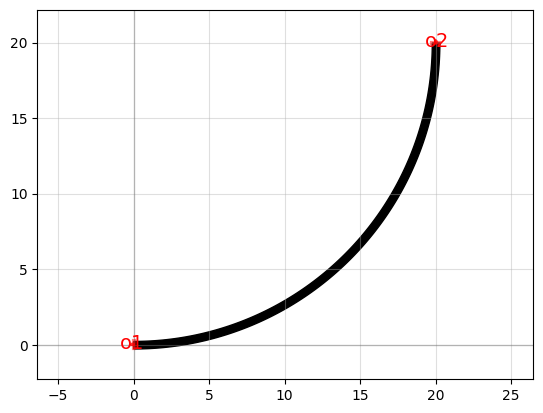

bend_circular_radius20: uid ac625690, ports ['o1', 'o2'], references [], 4 polygons

In [5]:
bend20 = partial(gf.components.bend_circular, radius=20)
b = bend20()
b

In [6]:
type(bend20)

functools.partial

In [7]:
bend20.func.__name__

'bend_circular'

In [8]:
bend20.keywords

{'radius': 20}

41.416


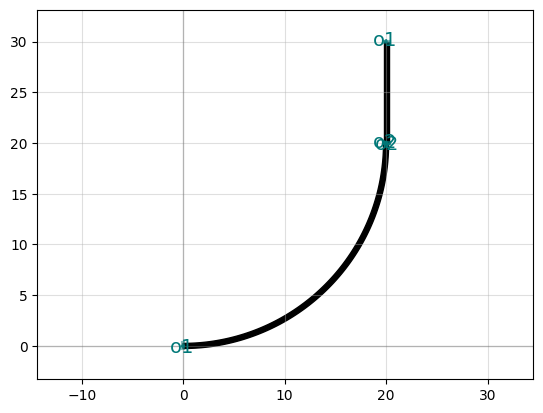

bend_with_straight_e917218d: uid 08d157db, ports [], references ['bend_circular_1', 'straight_1'], 0 polygons

In [9]:
b = bend_with_straight(bend=bend20)
print(b.metadata.info.length)
b

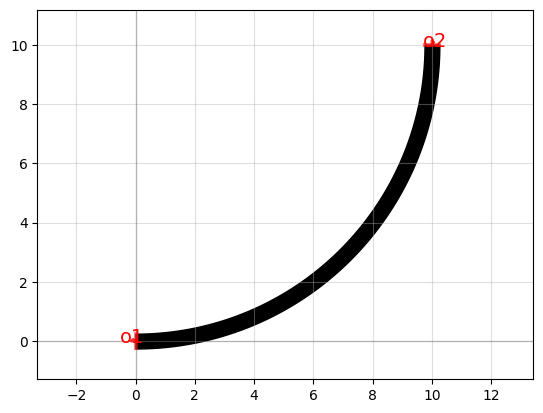

bend_circular_radius10: uid 54e63f9e, ports ['o1', 'o2'], references [], 4 polygons

In [10]:
# You can still modify the bend to have any bend radius
b3 = bend20(radius=10)
b3

## PDK custom fab

You can define a new PDK by creating function that customize partial parameters of the generic functions.

Lets say that this PDK uses layer (41, 0) for the pads (instead of the layer used in the generic pad function).

You can also access `functools.partial` from `gf.partial`

In [11]:
import gdsfactory as gf

pad = gf.partial(gf.components.pad, layer=(41, 0))

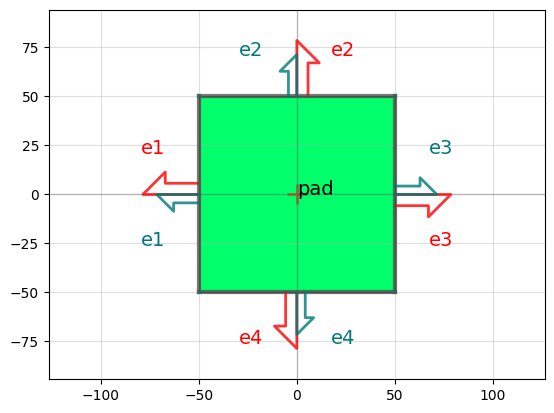

pad_layer41__0: uid ee910cdf, ports ['e1', 'e2', 'e3', 'e4', 'pad'], references ['compass_1'], 0 polygons

In [12]:
c = pad()
c

## Composing functions

You can combine more complex functions out of smaller functions.

Lets say that we want to add tapers and grating couplers to a wide waveguide.

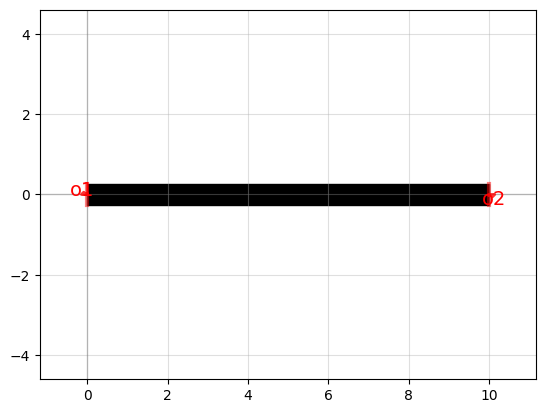

straight: uid 7ce74ad8, ports ['o1', 'o2'], references [], 4 polygons

In [13]:
c1 = gf.components.straight()
c1

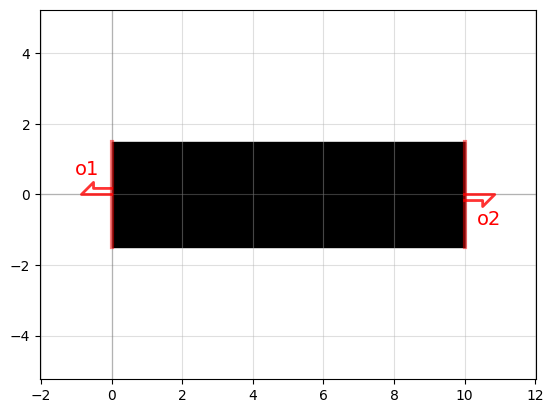

straight_width3: uid 8c3d1227, ports ['o1', 'o2'], references [], 4 polygons

In [14]:
straight_wide = gf.partial(gf.components.straight, width=3)
c3 = straight_wide()
c3

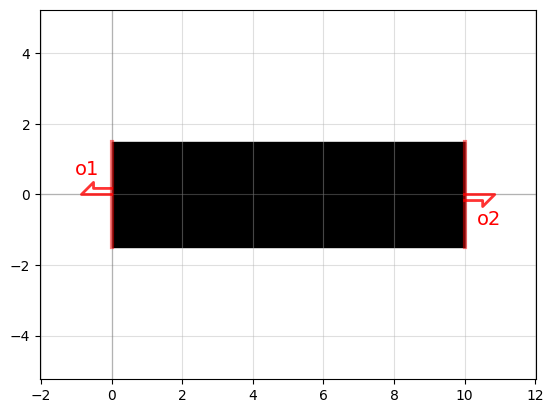

straight_width3: uid 8c3d1227, ports ['o1', 'o2'], references [], 4 polygons

In [15]:
c1 = gf.components.straight(width=3)
c1

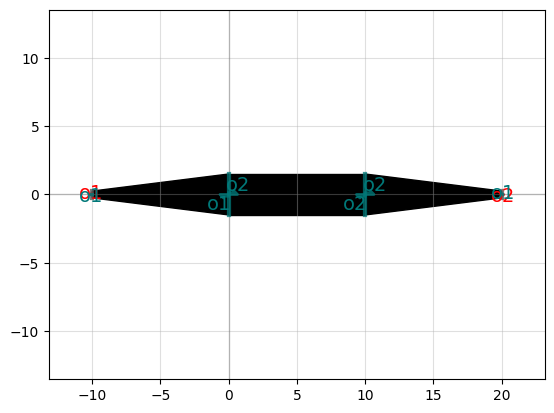

straight_width3_add_tap_85af842d: uid 69947137, ports ['o1', 'o2'], references ['taper_1', 'taper_2', 'straight_1'], 0 polygons

In [16]:
c2 = gf.add_tapers(c1)
c2

In [17]:
c2.metadata_child.changed  # You can still access the child metadata

{'width': 3}

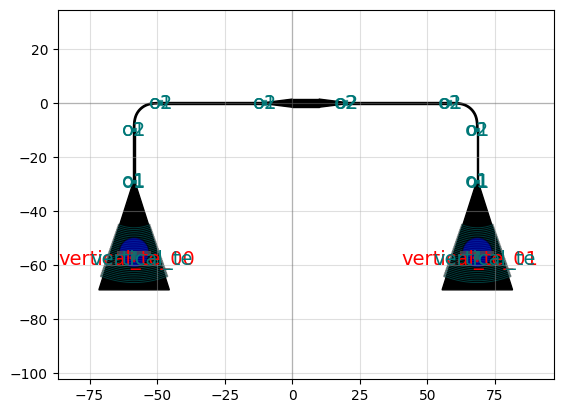

straight_width3_add_tap_408d8a8c: uid 92a56f4f, ports ['vertical_te_00', 'vertical_te_01'], references ['bend_euler_1', 'straight_1', 'straight_2', 'bend_euler_2', 'straight_3', 'straight_4', 'grating_coupler_elliptical_trenches_1', 'grating_coupler_elliptical_trenches_2', 'add_tapers_1'], 0 polygons

In [18]:
c3 = gf.routing.add_fiber_array(c2, with_loopback=False)
c3

In [19]:
c3.metadata_child.changed  # You can still access the child metadata

{'width': 3}

Lets do it with a **single** step thanks to `toolz.pipe`

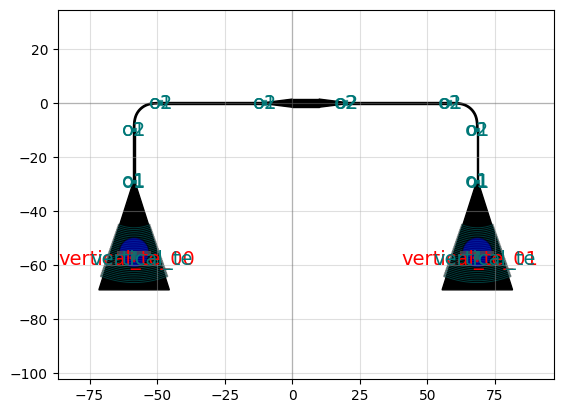

straight_width3_add_tap_408d8a8c: uid 92a56f4f, ports ['vertical_te_00', 'vertical_te_01'], references ['bend_euler_1', 'straight_1', 'straight_2', 'bend_euler_2', 'straight_3', 'straight_4', 'grating_coupler_elliptical_trenches_1', 'grating_coupler_elliptical_trenches_2', 'add_tapers_1'], 0 polygons

In [20]:
import toolz

add_fiber_array = gf.partial(gf.routing.add_fiber_array, with_loopback=False)
add_tapers = gf.add_tapers

# pipe is more readable than the equivalent add_fiber_array(add_tapers(c1))
c3 = toolz.pipe(c1, add_tapers, add_fiber_array)
c3

we can even combine `add_tapers` and `add_fiber_array` thanks to `toolz.compose` or `toolz.compose`

For example:

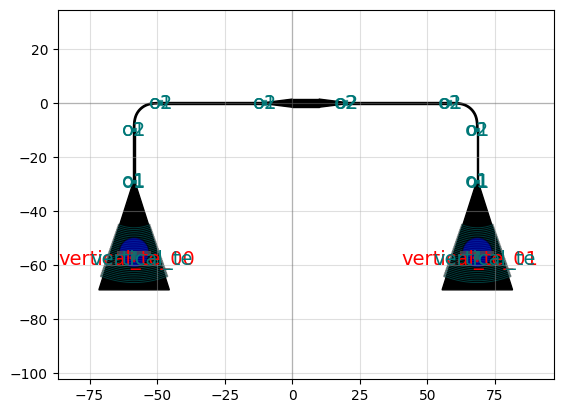

straight_width3_add_tap_408d8a8c: uid 92a56f4f, ports ['vertical_te_00', 'vertical_te_01'], references ['bend_euler_1', 'straight_1', 'straight_2', 'bend_euler_2', 'straight_3', 'straight_4', 'grating_coupler_elliptical_trenches_1', 'grating_coupler_elliptical_trenches_2', 'add_tapers_1'], 0 polygons

In [21]:
add_tapers_fiber_array = toolz.compose_left(add_tapers, add_fiber_array)
c4 = add_tapers_fiber_array(c1)
c4

is equivalent to

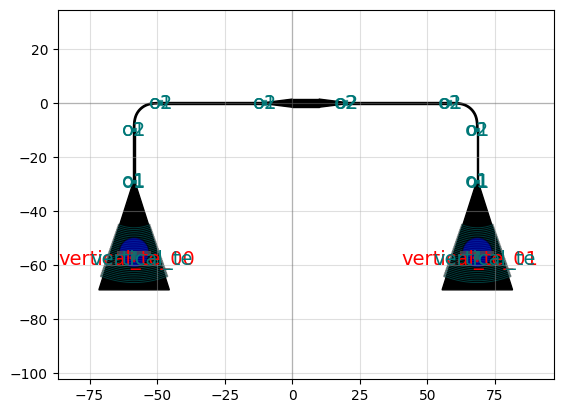

straight_width3_add_tap_408d8a8c: uid 92a56f4f, ports ['vertical_te_00', 'vertical_te_01'], references ['bend_euler_1', 'straight_1', 'straight_2', 'bend_euler_2', 'straight_3', 'straight_4', 'grating_coupler_elliptical_trenches_1', 'grating_coupler_elliptical_trenches_2', 'add_tapers_1'], 0 polygons

In [22]:
c5 = add_fiber_array(add_tapers(c1))
c5

as well as equivalent to

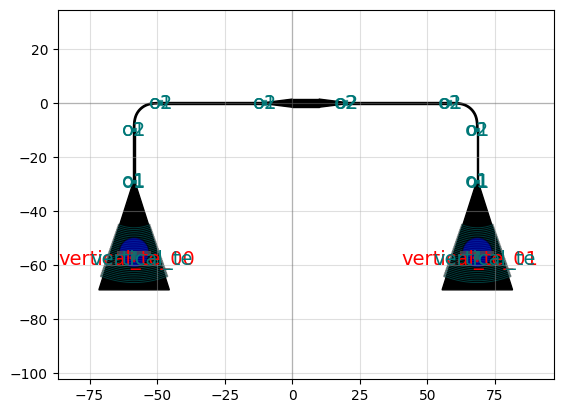

straight_width3_add_tap_408d8a8c: uid 92a56f4f, ports ['vertical_te_00', 'vertical_te_01'], references ['bend_euler_1', 'straight_1', 'straight_2', 'bend_euler_2', 'straight_3', 'straight_4', 'grating_coupler_elliptical_trenches_1', 'grating_coupler_elliptical_trenches_2', 'add_tapers_1'], 0 polygons

In [23]:
add_tapers_fiber_array = toolz.compose(add_fiber_array, add_tapers)
c6 = add_tapers_fiber_array(c1)
c6

or

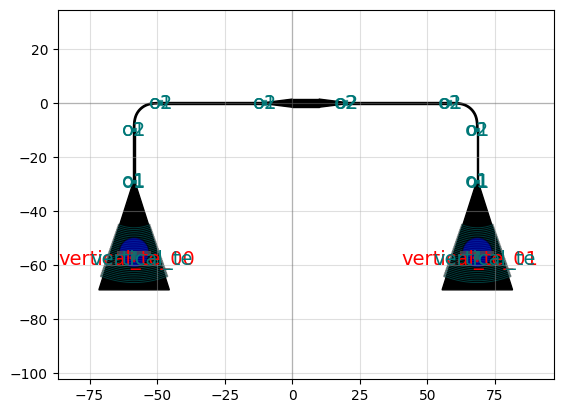

straight_width3_add_tap_408d8a8c: uid 92a56f4f, ports ['vertical_te_00', 'vertical_te_01'], references ['bend_euler_1', 'straight_1', 'straight_2', 'bend_euler_2', 'straight_3', 'straight_4', 'grating_coupler_elliptical_trenches_1', 'grating_coupler_elliptical_trenches_2', 'add_tapers_1'], 0 polygons

In [24]:
c7 = toolz.pipe(c1, add_tapers, add_fiber_array)
c7

In [25]:
c7.metadata_child.changed  # You can still access the child metadata

{'width': 3}

In [26]:
c7.metadata.child.child.name, c7.metadata.child.child.function_name

('straight_width3', 'straight')

In [27]:
c7.metadata.child.name, c7.metadata.child.function_name

('straight_width3_add_tap_85af842d', 'add_tapers')

In [28]:
c7.metadata.name, c7.metadata.function_name

('straight_width3_add_tap_408d8a8c', 'add_fiber_array')

In [29]:
c7.metadata.changed.keys()

dict_keys(['component', 'with_loopback'])